### Importando librerías

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = (256,256)
BATCH_SIZE = 32

### Importando imágenes 

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "archive\data",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [8]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

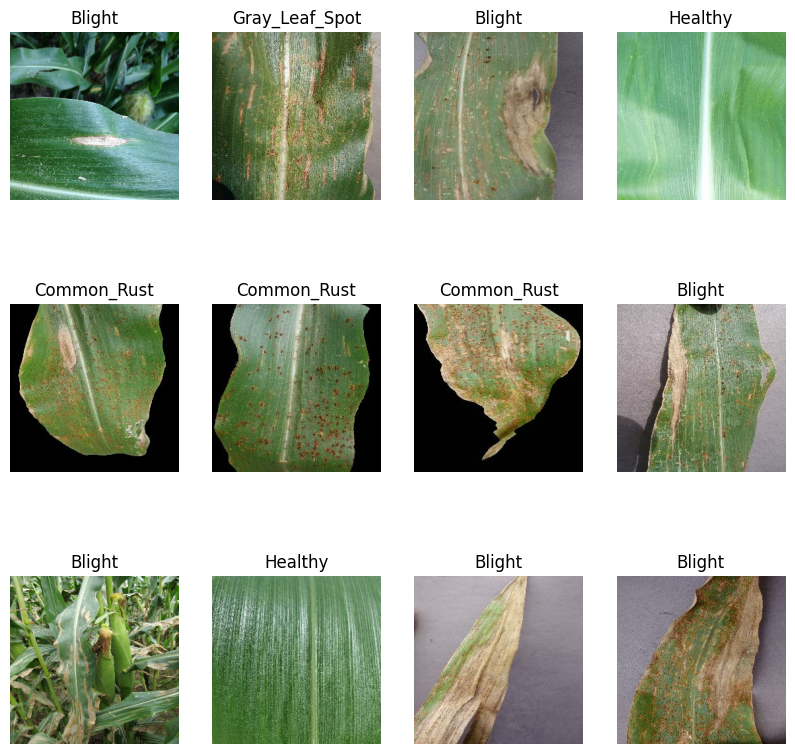

In [9]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Data Augmentation

In [11]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [12]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [13]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 104

Length of Validation Dataset is 13

Length of Testing Dataset is 14


In [15]:
# optimizaciones adicionales a los conjuntos de datos de entrenamiento, validación y prueba creados por la función get_dataset()
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Comparar modelos

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Definir una función para convertir cada batch de datos en una matriz bidimensional
def reshape_batch(X, y):
    batch_size = X.shape[0]
    X = X.reshape((batch_size, -1))
    return X, y

# Convertir el objeto tf.data.Dataset en un iterable de Python y aplicar el preprocesamiento de datos
data = []
for image_batch, label_batch in dataset:
    X, y = reshape_batch(image_batch.numpy(), label_batch.numpy())
    data.append((X, y))

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
X_train = np.concatenate([X for X, y in train_data])
y_train = np.concatenate([y for X, y in train_data])
X_test = np.concatenate([X for X, y in test_data])
y_test = np.concatenate([y for X, y in test_data])

In [49]:
# Crear un pipeline de Scikit-Learn que incluya el escalado de características, selección de características y entrenamiento de modelos
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [50]:
# Entrenar el pipeline de Scikit-Learn
pipeline.fit(X_train, y_train)

C:\Users\074002781\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [51]:
# Evaluar el desempeño del pipeline en el conjunto de prueba
accuracy = pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)

# Generar una matriz de confusión
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)

Accuracy: 0.8043981481481481
Confusion matrix:
[[173  11  27  17]
 [  9 254   6   6]
 [ 76   7  41   4]
 [  4   0   2 227]]


### Modelo CNN

In [19]:
n_classes = 4
input_shape = (BATCH_SIZE,256,256,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [21]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

### Fitting

In [19]:
history = model.fit(
train_ds,
epochs=40,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/40
104/104 [==============================] - 223s 2s/step - loss: 0.9572 - accuracy: 0.5259 - val_loss: 0.8291 - val_accuracy: 0.5938
Epoch 2/40
104/104 [==============================] - 166s 2s/step - loss: 0.8162 - accuracy: 0.6125 - val_loss: 0.7354 - val_accuracy: 0.7476
Epoch 3/40
104/104 [==============================] - 187s 2s/step - loss: 0.5594 - accuracy: 0.7705 - val_loss: 0.4219 - val_accuracy: 0.8413
Epoch 4/40
104/104 [==============================] - 177s 2s/step - loss: 0.4364 - accuracy: 0.8267 - val_loss: 0.3704 - val_accuracy: 0.8341
Epoch 5/40
104/104 [==============================] - 188s 2s/step - loss: 0.3541 - accuracy: 0.8520 - val_loss: 0.3502 - val_accuracy: 0.8630
Epoch 6/40
104/104 [==============================] - 187s 2s/step - loss: 0.3293 - accuracy: 0.8652 - val_loss: 0.3210 - val_accuracy: 0.8726
Epoch 7/40
104/104 [==============================] - 171s 2s/step - loss: 0.3227 - accuracy: 0.8694 - val_loss: 0.4539 - val_accuracy: 0.8389

In [20]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 16s 322ms/step - loss: 0.1806 - accuracy: 0.9353


In [22]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 104}

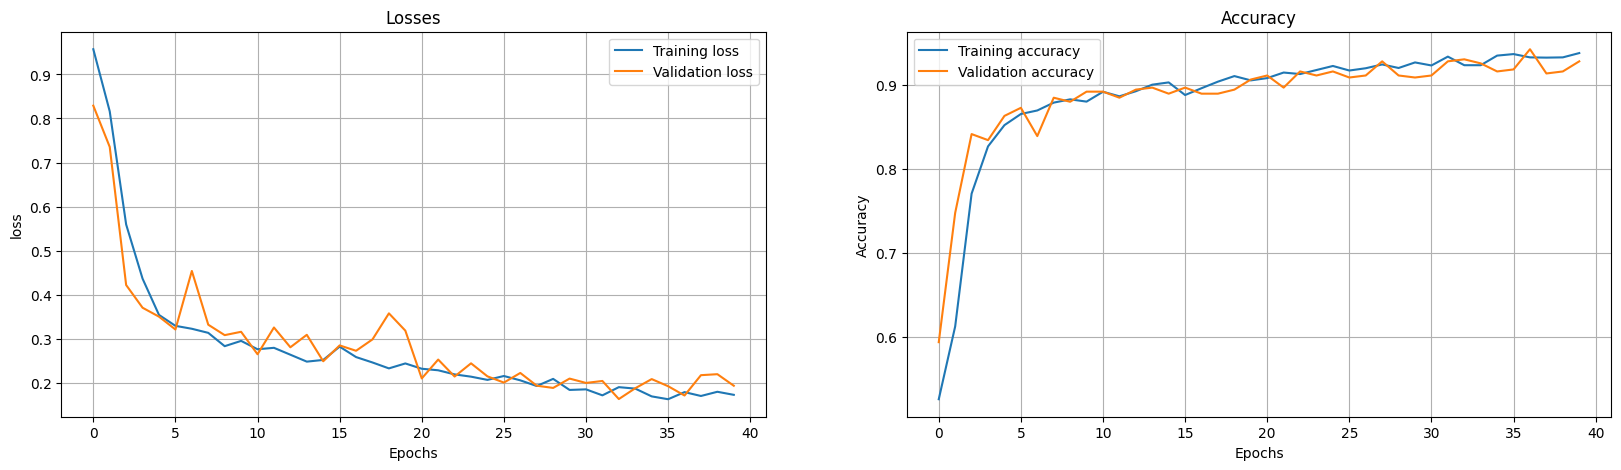

In [23]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

### Prediction

First Image to Predict :

Actual label: Healthy
1/1 [==============================] - 0s 492ms/step

Predicted label Healthy


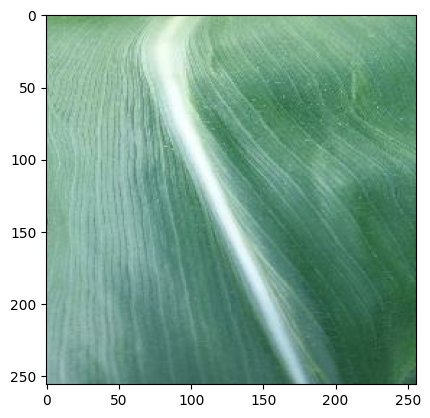

In [24]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model. predict (images_batch) 
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


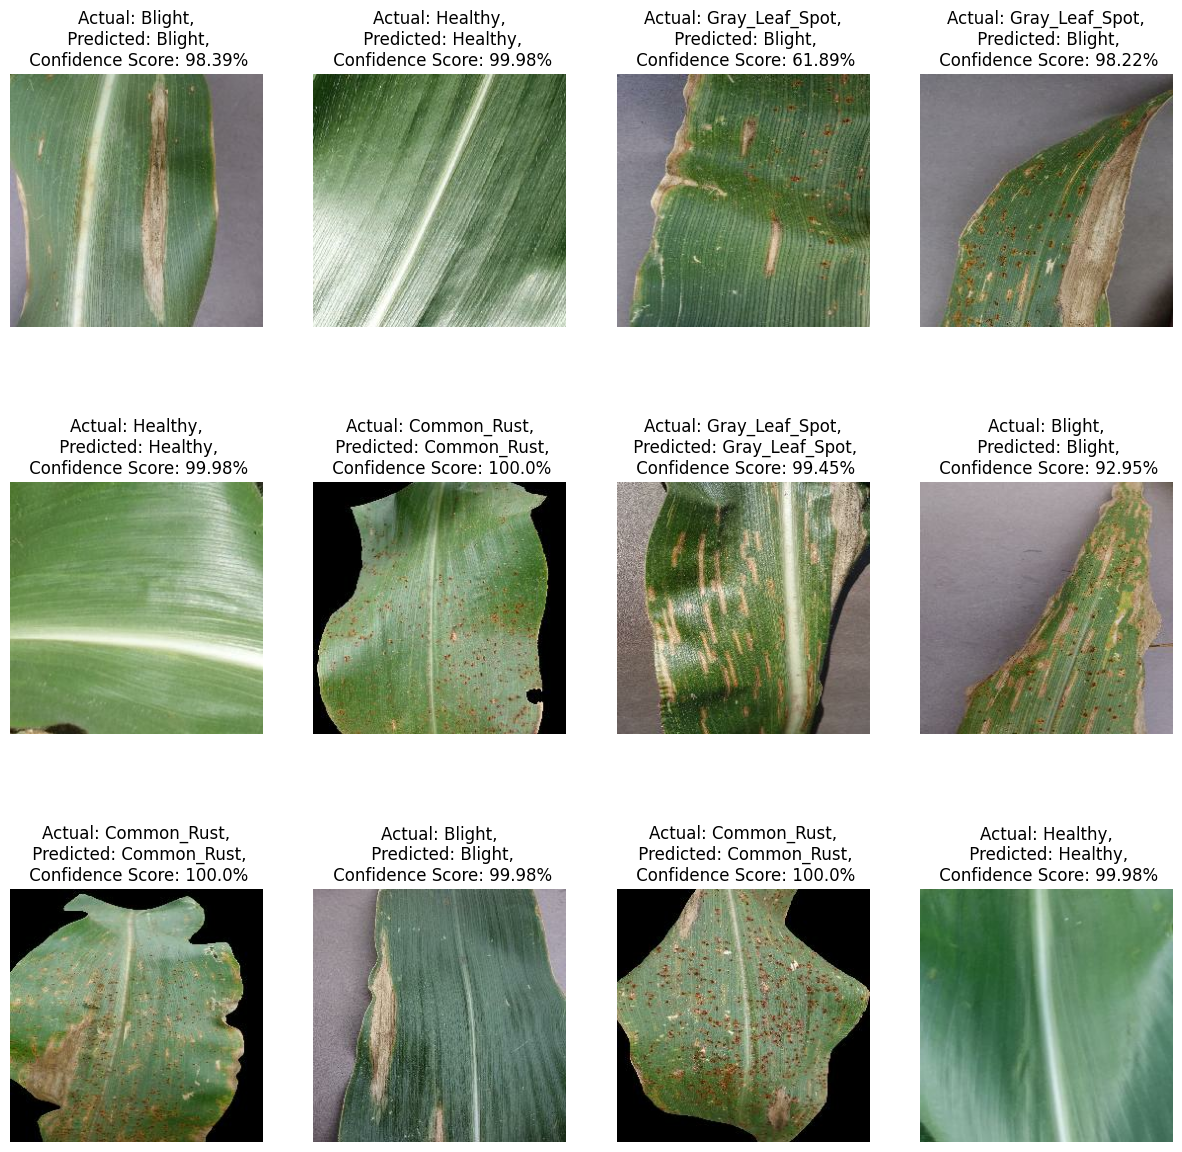

In [26]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [28]:
model.save('Proyecto final/model_1')

INFO:tensorflow:Assets written to: Proyecto final/model_1\assets


INFO:tensorflow:Assets written to: Proyecto final/model_1\assets
